<a href="https://colab.research.google.com/github/bailejor/SAMSHA_Transfer_Learning/blob/main/Heroin_transfer_opioid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer from heroin dataset to small non-heroin opioid set**

In this model transfer learning is implemented on a CNN model built from scratch. The model architecture from the CNN in experiment 1 are retained. This model was trained on a heroin use treatment dataset and then transfer learning occurs after replacing the sigmoid layer at the top of the model and allowing it to be trainable on half of the other opioid dataset. 

The opioid treatment dataset is small (1% of all non-heroin opioid treatment from 2018, n = ). It is meant to mimic clinical records that a treatment center in a large city or research lab would have access to. 

In [ ]:
pip install tf-nightly

In [ ]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Activation, Flatten, MaxPooling2D, Dropout
from keras.models import Sequential
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.models import Model
from keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, accuracy_score, roc_auc_score, fbeta_score, precision_recall_curve, precision_score, recall_score, f1_score, make_scorer, auc
from matplotlib import pyplot


In [ ]:
!unzip /content/drive/MyDrive/OpTrainImageshalf.nosync.zip

In [ ]:
!unzip /content/drive/MyDrive/OpTestImageshalf.nosync.zip

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/tedsd_puf_2018.csv', header  = 0)

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/tedsd_puf_2017.csv', header  = 0)

In [ ]:
test_dataset = image_dataset_from_directory('/content/OpTestImageshalf.nosync', image_size=(250, 250), color_mode='rgb', shuffle=False, labels = 'inferred', label_mode = 'binary')

Found 1161 files belonging to 2 classes.


Found 1161 files belonging to 2 classes.
Using 929 files for training.
Found 1161 files belonging to 2 classes.
Using 232 files for validation.


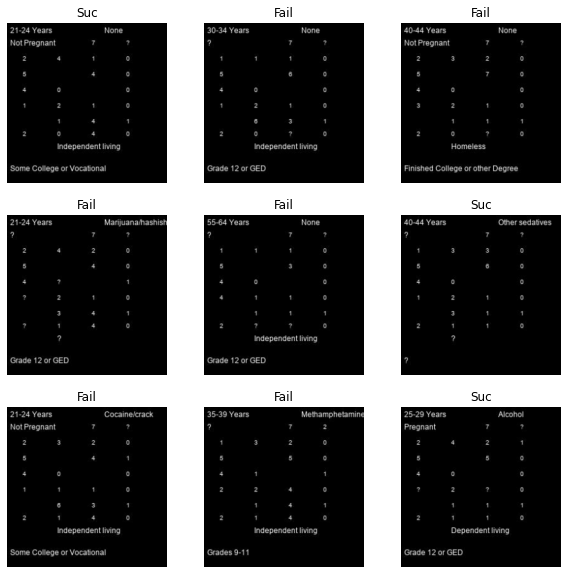

In [ ]:
train_dataset_op = image_dataset_from_directory(
    '/content/OpTrainImageshalf.nosync',
    validation_split=0.2,
    subset="training",
    seed=6,
    image_size=(250, 250),
    batch_size=32,
    shuffle = True,
    color_mode = 'rgb'
)

validation_dataset_op = image_dataset_from_directory(
    '/content/OpTrainImageshalf.nosync',
    validation_split=0.2,
    subset="validation",
    seed=6,
    image_size=(250, 250),
    batch_size=32,
    shuffle = True,
    color_mode = 'rgb'
)



class_names = train_dataset_op.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset_op.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+ 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [ ]:


model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(250, 250, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))





In [ ]:


model_new = Sequential()
model.trainable = False
#Copy the trained model
for layer in model.layers[:-1]:
  model_new.add(layer)

model_new.load_weights('/content/drive/MyDrive/best_model_hero.h5')
#Add in new activation layer
model_new.add(Activation('sigmoid'))
model_new.layers[-1].trainable = True
#model_new.layers[18].trainable = True

#For some reason this layer was set to trainable despite making the whole model untrainable

#model_new.trainable = True
#model_new.summary()
for layer in model_new.layers: print(layer, layer.trainable)          

callbacks = [EarlyStopping(monitor='val_loss', patience=3),
ModelCheckpoint(filepath='/content/drive/MyDrive/best_opi_model_smoll.h5', monitor='val_loss', save_best_only=True)]

#Recompile with all layers trainable and low learning rate
model_new.compile(loss = keras.losses.BinaryCrossentropy(from_logits=True), optimizer = keras.optimizers.Adam(),
              metrics=[keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.BinaryAccuracy(), keras.metrics.TruePositives(), keras.metrics.TrueNegatives(), keras.metrics.FalseNegatives(), keras.metrics.FalsePositives()])



model_new.fit(train_dataset_op, epochs = 15, verbose = 1, validation_data = validation_dataset_op, callbacks = callbacks)

<keras.layers.convolutional.Conv2D object at 0x7ff9324e1690> False
<keras.layers.core.Activation object at 0x7ff93435ced0> False
<keras.layers.pooling.MaxPooling2D object at 0x7ff93248fb90> False
<keras.layers.convolutional.Conv2D object at 0x7ff9324baf50> False
<keras.layers.core.Activation object at 0x7ff9324ba510> False
<keras.layers.pooling.MaxPooling2D object at 0x7ff92021ff90> False
<keras.layers.core.Dropout object at 0x7ff92021f350> False
<keras.layers.convolutional.Conv2D object at 0x7ff92021f390> False
<keras.layers.core.Activation object at 0x7ff9324bab50> False
<keras.layers.pooling.MaxPooling2D object at 0x7ff920237bd0> False
<keras.layers.convolutional.Conv2D object at 0x7ff920237250> False
<keras.layers.core.Activation object at 0x7ff92021f5d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7ff92024a8d0> False
<keras.layers.core.Dropout object at 0x7ff93248f090> False
<keras.layers.core.Flatten object at 0x7ff92028c750> False
<keras.layers.core.Dense object at 0x7f

/usr/local/lib/python3.7/dist-packages/keras/backend.py:4982: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


30/30 [==============================] - 32s 97ms/step - loss: 0.5602 - precision: 0.6633 - recall: 0.1147 - binary_accuracy: 0.7423 - true_positives: 17.3226 - true_negatives: 360.9355 - false_negatives: 122.0645 - false_positives: 8.6452 - val_loss: 0.5547 - val_precision: 0.9091 - val_recall: 0.1429 - val_binary_accuracy: 0.7371 - val_true_positives: 10.0000 - val_true_negatives: 161.0000 - val_false_negatives: 60.0000 - val_false_positives: 1.0000
Epoch 2/15
30/30 [==============================] - 2s 51ms/step - loss: 0.5189 - precision: 0.8606 - recall: 0.1179 - binary_accuracy: 0.7700 - true_positives: 15.9032 - true_negatives: 370.9677 - false_negatives: 118.6129 - false_positives: 3.4839 - val_loss: 0.5547 - val_precision: 0.9091 - val_recall: 0.1429 - val_binary_accuracy: 0.7371 - val_true_positives: 10.0000 - val_true_negatives: 161.0000 - val_false_negatives: 60.0000 - val_false_positives: 1.0000
Epoch 3/15
30/30 [==============================] - 2s 53ms/step - loss: 0.534

In [ ]:
pred[pred<0.5]=0
pred[pred>=0.5]=1

print(accuracy_score(test_labels, pred))
print(confusion_matrix(test_labels, pred))
print(precision_score(test_labels, pred))
print(recall_score(test_labels, pred))
print(fbeta_score(test_labels, pred, beta = 0.5))


0.7596899224806202
[[845   6]
 [273  37]]
0.8604651162790697
0.11935483870967742
0.38381742738589214


Test Transfer Model Against Tuned Random Forest

In [ ]:



df = pd.concat([df2, df])
df = df.drop_duplicates(subset = ['CASEID'], keep = 'first')
df['REASON'].replace({2:0, 3:0, 4:0, 5:0, 6:0, 7:0}, inplace = True)
df = df[['CASEID', 'AGE', 'GENDER', 'RACE', 'ETHNIC', 'MARSTAT', 'EDUC', 'VET', 'PREG', 'EMPLOY', 'LIVARAG', 'ARRESTS',  'METHUSE', 'PSOURCE','NOPRIOR', 'SUB1', 'FREQ1', 'FRSTUSE1', 'SUB2', 'SUB3', 'ROUTE1', 'ROUTE2', 'ROUTE3', 'ALCFLG', 'COKEFLG', 'MARFLG', 'METHFLG', 'OPSYNFLG','HERFLG', 'SERVICES', 'SERVICES_D', 'REASON']]


methadone_use_false = [2]
methadone_use_true = [1]
sub_1_opiates = [7]
sub_1_heroin = [5]
sub_1_others = [1, 2, 3, 4, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


#Create second dataframe with just methadone treatment patients
df_opiates = df

#df_methadone = df_methadone.loc[df_methadone['METHUSE'].isin(methadone_use_true)]
#Return patients whose primary substance use is opiates
df_opiates = df_opiates.loc[df_opiates['SUB1'].isin(sub_1_opiates)]

#Get all patients who use opiates but NOT heroin
df_opiates = df_opiates.loc[~df_opiates['SUB2'].isin(sub_1_heroin)]
df_opiates = df_opiates.loc[~df_opiates['SUB3'].isin(sub_1_heroin)]


data_opiates = df_opiates.values

X_opiate = data_opiates[:,1:29]
y_opiate = data_opiates[:,31:32].ravel()

X_opiate_90, X_opiate_10, y_heroin_90, y_opiate_10 = train_test_split(X_opiate, y_opiate, test_size=0.01, random_state=33)
X_optrain_5, X_optest_5, y_optrain_5, y_optest_5 = train_test_split(X_opiate_10,  y_opiate_10, test_size=0.50, random_state=33)



param_grid = {'bootstrap':[True, False],
'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
'max_features': ['auto', 'sqrt'],
'min_samples_leaf':[1, 2, 4],
'min_samples_split':[2, 5, 10],
'n_estimators': [50, 200, 400, 600, 800, 1000],
'class_weight': [{0:50, 1:50}, {0:10, 1:90}, {0:20, 1:80}, {0:30, 1:70}, None]}

roc_auc = make_scorer(roc_auc_score)
balanced = make_scorer(balanced_accuracy_score)
acc = make_scorer(accuracy_score)
fbeta = make_scorer(fbeta_score, beta = 0.5)
rf = RandomForestClassifier(random_state= 33)

clf = RandomizedSearchCV(rf, param_grid, n_iter = 10, scoring = fbeta, n_jobs = 4, cv = 3, random_state = 33)
search = clf.fit(X_optrain_5, y_optrain_5)
print(search.best_params_)
print(search.best_score_)


rf2 = RandomForestClassifier(**search.best_params_)
rf2.fit(X_optrain_5, y_optrain_5)

yhat = rf2.predict(X_optest_5)

tn, fp, fn, tp = confusion_matrix(y_optest_5, yhat).ravel()

score1 = roc_auc_score(y_optest_5, yhat)
score2 = balanced_accuracy_score(y_optest_5, yhat)
score3 = accuracy_score(y_optest_5, yhat)
score4 = fbeta_score(y_optest_5, yhat, beta = 0.5)
pos_precision = precision_score(y_optest_5, yhat, pos_label = 1)
pos_recall = recall_score(y_optest_5, yhat, pos_label = 1)

neg_precision = precision_score(y_optest_5, yhat, pos_label = 0)
neg_recall = recall_score(y_optest_5, yhat, pos_label = 0)
print(tn, fp, fn, tp)


print(y_optest_5)
print(yhat)
print("The Accuracy Score is: " + str(score3))
print("The F0.5 Score is: " + str(score4))
print("The positive precision is: " + str(pos_precision))
print("The positive recall is: " + str(pos_recall))
print("The negative precision is: " + str(neg_precision))
print("The negative recall is: " + str(neg_recall))


rf_thresh = rf2.predict_proba(X_optest_5)[:, 1].flatten()

precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_optest_5, rf_thresh)
rf_auc_precision_recall = auc(recall_rf, precision_rf)
print(rf_auc_precision_recall)


{'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 90, 'class_weight': {0: 10, 1: 90}, 'bootstrap': True}
0.363109258801287
829 22 273 37
[0 1 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
The Accuracy Score is: 0.7459086993970715
The F0.5 Score is: 0.33882783882783885
The positive precision is: 0.6271186440677966
The positive recall is: 0.11935483870967742
The negative precision is: 0.7522686025408348
The negative recall is: 0.9741480611045829
0.4320439092592676


Compare precision-recall curve of random forest and CNN transfer model

0.49236344734862014


Text(0, 0.5, 'Precision')

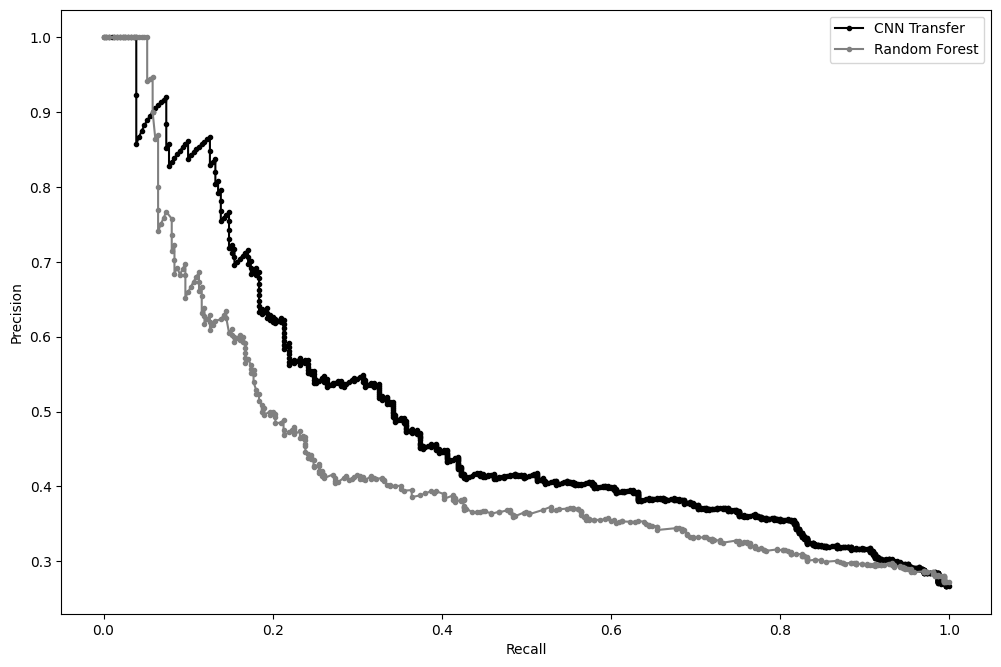

In [ ]:
model_new.load_weights('/content/drive/MyDrive/best_opi_model.h5')

test_labels = []
test_classes = test_dataset.class_names
for images, labels in test_dataset:
  test_labels.append(labels)
test_labels = np.concatenate(test_labels, axis=0 )
test_labels = test_labels.flatten()


pred = model_new.predict(test_dataset)
pred = pred.flatten()

precision, recall, thresholds = precision_recall_curve(test_labels, pred)

nn_auc_precision_recall = auc(recall, precision)
print(nn_auc_precision_recall)

pyplot.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
pyplot.plot(recall, precision, marker='.', label='CNN Transfer', color = 'k')
pyplot.plot(recall_rf, precision_rf, marker='.', label='Random Forest', color = 'gray')
pyplot.legend()
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')



